In [1]:
import os
import xml.etree.ElementTree as ET
import cv2

In [2]:
# Original dataset path
dataset_base = "/kaggle/input/waste-detection-dataset/Construction and Demolition Waste Object Detection Dataset  (CODD)"

# Output YOLO-ready dataset path
output_base = "/kaggle/working/waste-yolo"

# Create folders
for split in ["training", "validation", "testing"]:
    os.makedirs(f"{output_base}/{split}/images", exist_ok=True)
    os.makedirs(f"{output_base}/{split}/labels", exist_ok=True)

In [3]:
classes = set()
for split in ["training", "validation", "testing"]:
    split_path = os.path.join(dataset_base, split)
    for file in os.listdir(split_path):
        if file.endswith(".xml"):
            tree = ET.parse(os.path.join(split_path, file))
            root = tree.getroot()
            for obj in root.iter("object"):
                classes.add(obj.find("name").text)

classes = sorted(list(classes))
print("Detected classes:", classes)

Detected classes: ['brick', 'concrete', 'foam', 'general_w', 'gypsum_board', 'pipes', 'plastic', 'stone', 'tile', 'wood']


In [4]:
def convert_bbox(size, box):
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x = (box[0] + box[1]) / 2.0 - 1
    y = (box[2] + box[3]) / 2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

def convert_annotation(xml_path, txt_path, img_shape, classes):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    with open(txt_path, "w") as out_file:
        for obj in root.iter("object"):
            cls = obj.find("name").text
            if cls not in classes:
                continue
            cls_id = classes.index(cls)
            xmlbox = obj.find("bndbox")
            b = (
                float(xmlbox.find("xmin").text),
                float(xmlbox.find("xmax").text),
                float(xmlbox.find("ymin").text),
                float(xmlbox.find("ymax").text),
            )
            bb = convert_bbox(img_shape, b)
            out_file.write(f"{cls_id} {' '.join([str(a) for a in bb])}\n")

In [5]:
for split in ["training", "validation", "testing"]:
    split_path = os.path.join(dataset_base, split)
    for file in os.listdir(split_path):
        if file.endswith(".jpg"):
            # Copy image
            img_src = os.path.join(split_path, file)
            img_dst = os.path.join(output_base, split, "images", file)
            os.system(f"cp '{img_src}' '{img_dst}'")

            # Convert XML → TXT
            xml_file = file.replace(".jpg", ".xml")
            xml_path = os.path.join(split_path, xml_file)
            if os.path.exists(xml_path):
                txt_path = os.path.join(output_base, split, "labels", file.replace(".jpg", ".txt"))
                img = cv2.imread(img_src)
                h, w, _ = img.shape
                convert_annotation(xml_path, txt_path, (w, h), classes)

In [6]:
yaml_content = f"""
train: {output_base}/training
val: {output_base}/validation
test: {output_base}/testing

nc: {len(classes)}
names: {classes}
"""

with open("/kaggle/working/data.yaml", "w") as f:
    f.write(yaml_content)

print("data.yaml created")

data.yaml created


In [7]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [8]:
from ultralytics import YOLO
model = YOLO("yolov8s.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
model.train(
    data="/kaggle/working/data.yaml",
    epochs=50,      
    imgsz=640,
    batch=16,
    workers=2        
)

Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tru

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        570       3236      0.881      0.734      0.834      0.793
                 brick         86        372      0.977      0.938      0.968      0.953
              concrete         86        364      0.962      0.934      0.975      0.963
                  foam         49        295       0.72      0.749      0.781      0.731
             general_w        121        287      0.829      0.712      0.797      0.746
          gypsum_board         30        276          1       0.89      0.939      0.919
                 pipes         55        260      0.771      0.442      0.668      0.563
               plastic         97        306      0.615      0.595      0.599      0.525
                 stone         43        245          1      0.475      0.723      0.707
                  tile         84        346      0.959      0.922      0.965       0.95
                  wood        190        485      0.976      0.683      0.926      0.876
Speed: 0.1ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cfc506f96d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [10]:
model.val(data="/kaggle/working/data.yaml")

Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2055.4±1035.8 MB/s, size: 189.9 KB)
val: Scanning /kaggle/working/waste-yolo/validation/labels.cache... 570 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 570/570 833.6Kit/s 0.0s
val: /kaggle/working/waste-yolo/validation/images/gen-1029.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 36/36 6.4it/s 5.6s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        570       3236      0.881      0.734      0.834      0.794
                 brick         86        372      0.977      0.938      0.968      0.953
              concrete         86        364      0.962      0.934      0.975      0.966
                  foam         49        295       0.72      0.749      0.781      0.731
             general_w        121        287       0.83      0.711      0.796      0.746
          gypsum_board         30        276          1       0.89      0.939      0.921
                 pipes         55        260      0.771      0.442      0.668      0.567
               plastic         97        306      0.616      0.597      0.599      0.525
                 stone         43        245          1      0.475      0.723      0.707
                  tile         84        346      0.959      0.922      0.965      0.954
                  wood        190        485      0.976      0.683      0.926      0.876
Speed: 0.5ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cfc48332c90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [11]:
model.export(format="onnx")   # for deployment, e.g., ONNX, TorchScript, etc.

Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/kaggle/working/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (21.5 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.67', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 4.8s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.18.0 opset 19...
ONNX: slimming with onnxslim 0.1.70...
ONNX: export success ✅ 7.5s, saved as '/kaggle/working/runs/detect/train/weights/best.onnx' (42.7 MB)

Export complete (8.1s)
Results saved to /kaggle/working/runs/detect/train/weights
Predict:         yolo predict task=detect model=/kaggle/working/runs/detect/train/weights/best.

'/kaggle/working/runs/detect/train/weights/best.onnx'


image 1/573 /kaggle/working/waste-yolo/testing/images/1.jpg: 416x640 4 bricks, 5 concretes, 4 tiles, 38.5ms
image 2/573 /kaggle/working/waste-yolo/testing/images/103.jpg: 416x640 4 bricks, 4 concretes, 4 tiles, 6.0ms
image 3/573 /kaggle/working/waste-yolo/testing/images/109.jpg: 416x640 7 bricks, 9 concretes, 6.4ms
image 4/573 /kaggle/working/waste-yolo/testing/images/113.jpg: 416x640 4 bricks, 5 concretes, 4 tiles, 5.9ms
image 5/573 /kaggle/working/waste-yolo/testing/images/12.jpg: 416x640 4 bricks, 4 concretes, 5 tiles, 5.9ms
image 6/573 /kaggle/working/waste-yolo/testing/images/123.jpg: 416x640 4 bricks, 5 concretes, 6 tiles, 6.0ms
image 7/573 /kaggle/working/waste-yolo/testing/images/128.jpg: 416x640 4 bricks, 4 concretes, 5 tiles, 5.9ms
image 8/573 /kaggle/working/waste-yolo/testing/images/129.jpg: 416x640 4 bricks, 5 concretes, 3 tiles, 5.9ms
image 9/573 /kaggle/working/waste-yolo/testing/images/134.jpg: 416x640 4 bricks, 5 concretes, 4 tiles, 5.9ms
image 10/573 /kaggle/working/

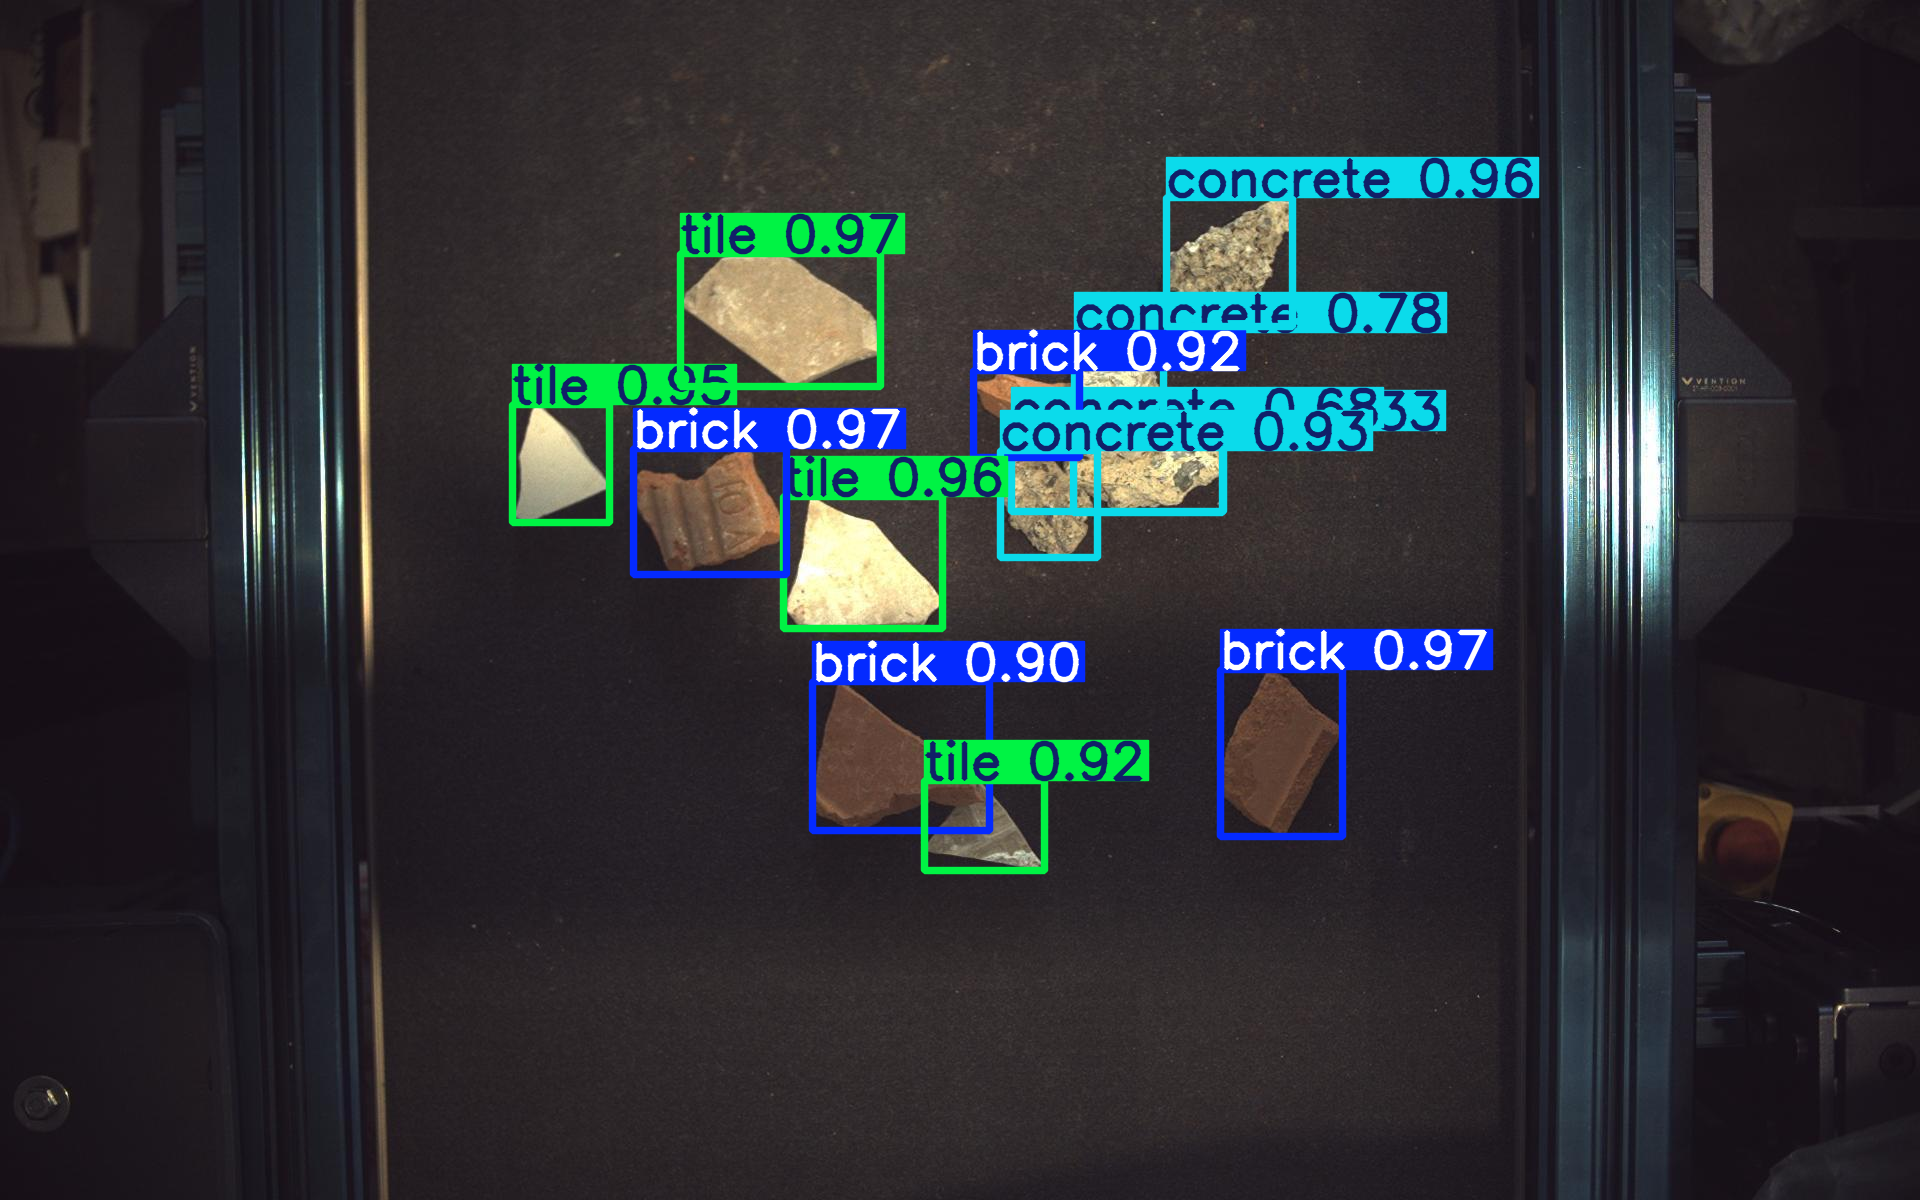

In [12]:
# Run inference on a sample image
results = model.predict(source="/kaggle/working/waste-yolo/testing/images", imgsz=640, conf=0.25)

results[0].show()